In [50]:
import os, re
from functools import partial
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sgutil, sgml


for i in [pd, np, sns, mpl]:
    print(i.__name__, i.__version__)

pandas 2.2.2
numpy 1.26.4
seaborn 0.13.2
matplotlib 3.8.4


In [55]:
# 주요 파일의 경로를 설정합니다.
data_path = 'data'
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'data.csv'),
        ('train_pkl', data_path, 'train.pkl'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_pkl', data_path, 'test.pkl'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}
# fig, result cache 처리기를 생성합니다.
sc = sgutil.SGCache('img', 'result')
# 처리된 데이터를 불러옵니다.
df_train = pd.read_pickle(files['train_pkl'])
df_test = pd.read_pickle(files['test_pkl'])
df_org = pd.read_pickle(files['org_pkl'])
df_var = pd.read_pickle(files['var_pkl'])
# 변수를 유형별로 정리합니다.
target = 'Target'
X_cat = [i for i in df_var.loc[df_var['src'] == 'filtering_cat_val'].index.tolist() if i != target]
X_cat_o = [i for i in df_var.loc[df_var['src'] == 'ord'].index.tolist() if i != target]
X_bool = [
    'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'International'
]
X_ord = ['Application order']
X_num = df_var.loc[(~df_var.index.isin(X_cat + X_bool + X_ord + X_cat_o + [target])) & df_var['Type'].notna()].index.tolist()
X_all = X_cat_o + X_bool + X_ord + X_num
target_values = np.sort(df_train[target].unique().astype(str))

In [56]:
df_train.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

cv5 = StratifiedKFold(5, random_state=123, shuffle=True)

In [88]:
def predict(m, df, X):
    return pd.DataFrame(m.predict_proba(df[X])[:, :-1], index=df.index, columns=target_values[:-1])

def eval_metric(df, y_prd):
    y_prd = y_prd.assign(
        **{target_values[-1]: lambda x: 1 - x.sum(axis=1)}
    ).idxmax(axis=1)
    return accuracy_score(df[target], y_prd)

def print_metrics(valid_metrics, train_metrics):
    print('Valid.: {:.5f}±{:.5f}, Train: {:.5f}±{:.5f}'.format( 
        np.mean(valid_metrics), np.std(valid_metrics),
        np.mean(train_metrics), np.std(train_metrics),
    ))

def show_gb_cv_result(gb_result, train_result, metric='multi_logloss'):
    if train_result is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        df = pd.concat([i[0] for i in train_result], axis=0)[metric].reset_index().rename(columns={'index': 'round'}).groupby('round').mean()
        sns.lineplot(df.loc[df.iloc[:, 0] > 0], ax=axes[0])
        sns.barplot(
            pd.concat([i[1] for i in train_result], axis=0).rename('importance').reset_index().rename(columns={'index': 'feature'})\
                .groupby('feature').mean().sort_values('importance', ascending=False).iloc[:15],
            x='importance', y='feature', ax=axes[1]
        )
        plt.tight_layout()
        plt.show()
        print_metrics(gb_result['valid_metrics'], gb_result['train_metrics'])

In [89]:
stk = sgml.SGStacking(df_train, target, sp=cv5, predict_func=predict, eval_metric=eval_metric, greater_better=True)

# LightGBM

In [90]:
import lightgbm as lgb
lgb_eval = partial(stk.eval_model, model=lgb.LGBMClassifier, result_proc=sgml.lgb_learning_result)

In [93]:
m, train_result = lgb_eval('lgb1', model_params={'verbose': -1, 'n_estimators': 1000, 'colsamples_bytree': 0.25}, X=X_all, 
        train_params={'fit_params': {'categorical_feature': X_cat_o},  
                      'valid_config_proc': sgml.gb_valid_config})

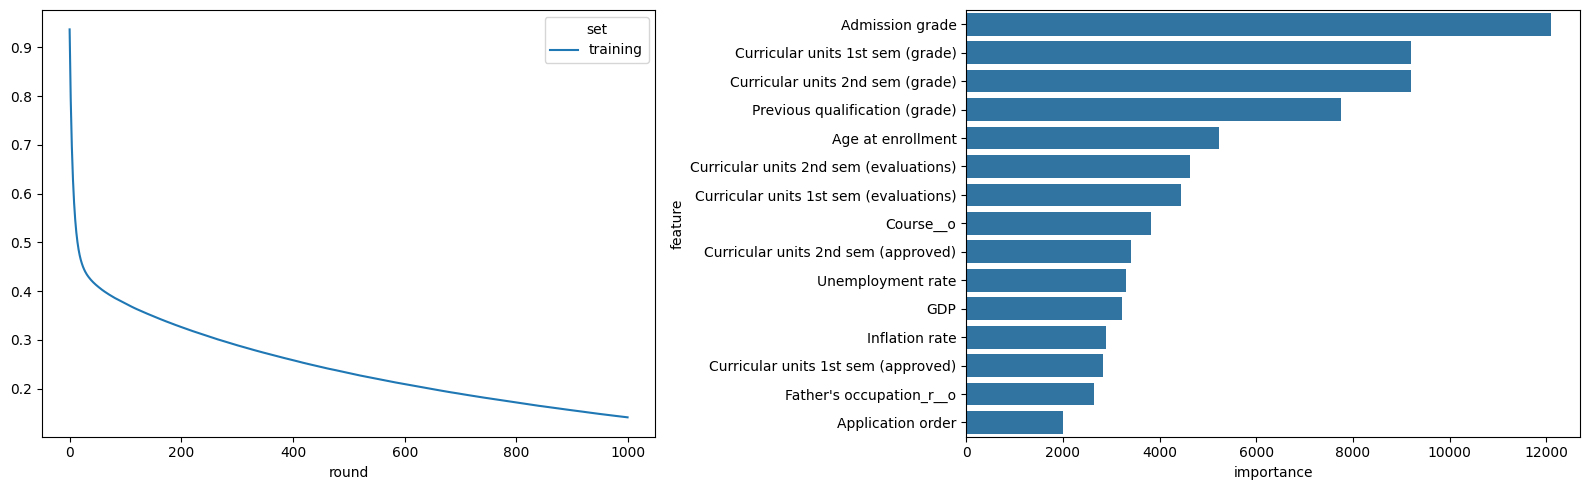

Valid.: 0.82896±0.00169, Train: 0.96874±0.00032


In [94]:
show_gb_cv_result(m, train_result)